# Dataset Pre-Processing


First, download the dataset from kaggle and then load it into a pandas.DataFrame, then standardize its columns using MinStdScaler and finally define the CVI (ControVersiality Index) and HCC (Highly Controversial Comment) columns. 

## Load 

In [1]:
import os
from google.colab import files

if 'kaggle.json' not in os.listdir():
  files.upload()

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
import kaggle
import pandas as pd
import zipfile

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

class DatasetLoader():

  def __init__(self, month, year):
    self.api = api
    self.year = year
    self.month = month

  def download_dataset(self):
    self.api.dataset_download_file("aashita/nyt-comments", 
                                   file_name=f"Articles{self.month}{self.year}.csv", 
                                   path="./")
    self.api.dataset_download_file("aashita/nyt-comments", 
                                   file_name=f"Comments{self.month}{self.year}.csv", 
                                   path="./")

    with zipfile.ZipFile(f'Comments{self.month}{self.year}.csv.zip', 'r') as zipref:
      zipref.extractall('./')

  def _df(self, keepme=['default']):
    if keepme == ['default']:
      keepme = ['articleID', 'commentBody', 'snippet', 'keywords', \
                'recommendations', 'replyCount', 'editorsSelection', 'newDesk']

    articles = pd.read_csv(f'Articles{self.month}{self.year}.csv')
    comments = pd.read_csv(f'Comments{self.month}{self.year}.csv')

    df = comments.join(articles.set_index('articleID'), 
                       on='articleID', lsuffix='_') \
                 .set_index('commentID') 

    df = df[keepme][df.replyCount >= 0]
    df.editorsSelection = df.editorsSelection.astype(int)
    df.index = df.index.astype(int)

    return df

In [3]:
DL = DatasetLoader('April', 2017)
DL.download_dataset()
dfCom = DL._df()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Already a possible expansion would be to learn the atagory using hte information about a comment

## Define CVI, HCC

I want ot identify controversial comments, that are comment which had lots of replies and of recommendations. To do so, I stadardized the `replyCount` and `recommendations` to be scaled in standard deviations from their minimum (that is 0 for both), then computed the harmonic average of the two to get the `CVI`(ControVersiality Index) of the comment. \\
Note that in this phase I will not use `editorsSelection` as i wanted to focus on user-user interaction. 

In [4]:
import numpy as np

from numpy import vectorize
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from numba import jit, njit


class MinStdScaler(BaseEstimator):

  def __init__(self):
    super().__init__()

  @jit(forceobj=True)
  def fit_transform(self, v : np.ndarray):
    return (v - v.min()) / v.std()

@vectorize
@njit
def hmean(x, y):
  return 2/(1/x + 1/y) if x*y > 0 else 0

def CVI(df):
  try:
    df.CVI    
    return df
  except AttributeError:
    pass

  scaler = MinStdScaler()
  temp = df.copy()
  temp.replyCount = scaler.fit_transform(temp.replyCount.values.reshape(-1, 1))
  temp.recommendations = scaler.fit_transform(temp.recommendations.values \
                                                                  .reshape(-1, 1))
  temp['CVI'] = hmean(temp.replyCount, temp.recommendations)

  return temp

In [5]:
dfCom = CVI(dfCom)

In [6]:
dfCom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243830 entries, 22022598 to 22252040
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   articleID         243830 non-null  object 
 1   commentBody       243830 non-null  object 
 2   snippet           243830 non-null  object 
 3   keywords          243830 non-null  object 
 4   recommendations   243830 non-null  float64
 5   replyCount        243830 non-null  float64
 6   editorsSelection  243830 non-null  int64  
 7   newDesk           243830 non-null  object 
 8   CVI               243830 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 18.6+ MB


Now that there is a measure for controversiality, what makes a comment a controversial one?
My first idea was to use outliers, but `CVI` has far too many zeros for it to be effective. 

CVI is not zero for 39769 out of         243830 occurrences


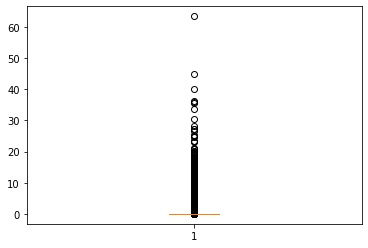

In [7]:
import matplotlib.pyplot as plt

print(f'CVI is not zero for {len(dfCom.CVI[dfCom.CVI > 0])} out of \
        {len(dfCom.CVI)} occurrences')

plt.boxplot(dfCom.CVI)
plt.show()

So eventually I settled for considering an HCC any comment with a CVI above the 99th percentile. 

In [8]:
def HCC(df, top_prc=1):
  temp = CVI(df.copy())
  cutoff = np.percentile(temp.CVI, 100-top_prc) 
  temp['HCC'] = (temp.CVI >= cutoff).astype(int)

  return temp

In [9]:
dfCom = HCC(dfCom)

In [10]:
dfCom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243830 entries, 22022598 to 22252040
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   articleID         243830 non-null  object 
 1   commentBody       243830 non-null  object 
 2   snippet           243830 non-null  object 
 3   keywords          243830 non-null  object 
 4   recommendations   243830 non-null  float64
 5   replyCount        243830 non-null  float64
 6   editorsSelection  243830 non-null  int64  
 7   newDesk           243830 non-null  object 
 8   CVI               243830 non-null  float64
 9   HCC               243830 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 20.5+ MB


# Features of HCCs

Now that HCCs have been identified, what are their features?

## Vocabulary

In [11]:
%%capture
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

In [12]:
import spacy
import re
import string

from io import StringIO
from nltk.tokenize import ToktokTokenizer
from html.parser import HTMLParser
from nltk.stem.wordnet import WordNetLemmatizer

# https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python 
class MLStripper(HTMLParser):

  def __init__(self):
    super().__init__()
    self.reset()
    self.strict = False
    self.convert_charrefs= True
    self.text = StringIO()

  def handle_data(self, d):
    self.text.write(d)

  def get_data(self):
    return self.text.getvalue()

def strip_tags(html):
  s = MLStripper()
  s.feed(html)
  return s.get_data()

class NaiveTokenizer(object):

  def __init__(self):
    pass

  def tokenize(self, text, remove_stopwords=False):
    if not remove_stopwords: 
      return re.sub(f'[^a-zA-Z]', ' ', text.lower()).split() 
    else:
      return [x for x in re.sub('[^a-zA-Z]', ' ', text.lower())
                           .split()
                if x not in stopwords.words('english')]

class TextProcessor(BaseEstimator):

  def __init__(self, how='lem', remove_html_tags=False):

    try:
      assert how in {'tok', 'lem'}
    except:
      print("Set 'how' to 'tok' to tokenize, to 'lem' to lemmatize")
      return 
    
    super().__init__()
    self.lemmatizer = WordNetLemmatizer()
    self.html_parser = MLStripper()
    self.tokenizer = NaiveTokenizer()
    self.how = how
    self.remove_html_tags = remove_html_tags

  def fit(self, text):
    self.text = text

  def detect_html(self):
    return True if re.search(r'<.{0,20}>', self.text) else False
    
  def strip_html_tags(self):
    self.html_parser.feed(self.text)
    self.text = self.html_parser.get_data()

  def tokenize(self):
    self.tokens = [x for x in self.tokenizer.tokenize(self.text) \
                   if len(x) > 1]
    return self.tokens

  def lemmatize(self):
    self.lemmas = [self.lemmatizer.lemmatize(w) for w in self.tokens]
    return self.lemmas

  def fit_transform(self, text):
    
    self.fit(text)
    if self.remove_html_tags and self.detect_html():
        self.strip_html_tags()

    self.tokenize()

    if self.how == 'tok': 
      return self.tokens

    if self.how == 'lem':
      self.lemmatize()
      return self.lemmas

In [13]:
dfTxt = dfCom[['commentBody', 'HCC']]

tp = TextProcessor(how='lem', remove_html_tags=False)
dfTxt.commentBody = dfTxt.commentBody.apply(lambda text: tp.fit_transform(text))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
dfTxt.commentBody

commentID
22022598    [this, project, make, me, happy, to, be, year,...
22017350    [stunning, photo, and, reportage, infuriating,...
22017334    [brilliant, work, from, conception, to, execut...
22015913    [nyt, reporter, should, provide, contributor, ...
22015466    [could, only, have, been, done, in, print, stu...
                                  ...                        
22257227    [sorry, but, pudding, ha, nothing, to, do, wit...
22257466    [while, it, would, be, quite, punny, to, spell...
22259265       [see, above, comment, desert, is, the, proper]
22250099    [john, rubinstein, had, two, brief, scene, wit...
22252040    [ye, god, and, little, fish, stu, you, re, rig...
Name: commentBody, Length: 243830, dtype: object

In [15]:
import string

from collections import Counter
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

def vocabulary(tkCorpus, verbose=True):
  if verbose:
    print('Counting occurrences')
    voc = Counter()
    for document in tqdm(tkCorpus): 
      voc.update(document)
  else:
    voc = Counter()
    for document in tkCorpus: 
      voc.update(document)

  if verbose: 
    print('Rescaling the vocabularies')
    
  s = sum(voc.values(), 0.0)
  for k, v in voc.items():
    voc[k] = v/s
  return voc

def klDiv(x, y):
  if x == 0:
    return 0
  elif y == 0:
    return np.Inf
  else:
    return x*np.log(x/y)

def klScores(voc1, voc2, filter=True):
  custom = {'br'} 
  stop = set(stopwords.words('english')).union(set(string.punctuation)) \
                                        .union(custom) \
                                        if filter else set()

  scores = Counter()
  for k in tqdm(set((voc1&voc2).keys()).difference(stop)):
    scores[k] = klDiv(voc1[k], voc2[k])
  return scores

Let's see how the vocabulary of Non Controversial comments (NC) and that of HCCs differ, using Kullback-Leilber divergence. 

In [16]:
vocNC = vocabulary(dfTxt[dfTxt.HCC == 0].commentBody)
vocHCC = vocabulary(dfTxt[dfTxt.HCC == 1].commentBody) 

Counting occurrences



Rescaling the vocabularies
Counting occurrences



Rescaling the vocabularies


In [17]:
a = klScores(vocHCC, vocNC, filter=True).most_common(10)

for (word, score) in a:
  print(word, ':', f'{score:.05f}')


trump : 0.00181
president : 0.00089
warn : 0.00077
republican : 0.00065
american : 0.00053
tax : 0.00050
donald : 0.00044
voter : 0.00039
country : 0.00033
health : 0.00032


## Length

The histograms of comments length show a clear dissimilarity of the two distributions, controversial comments having a much thicker tail. 

In [18]:
lenHCC = dfTxt.commentBody[dfTxt.HCC == 1].apply(len)
lenNC = dfTxt.commentBody[dfTxt.HCC == 0].apply(len)

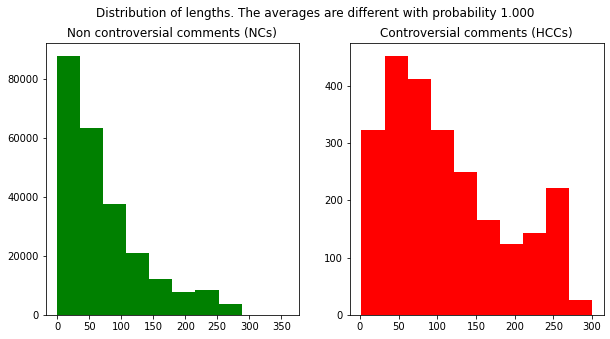

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

pval = ttest_ind(lenHCC, lenNC).pvalue

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle(f'Distribution of lengths. The averages are different with probability {1-pval:.03f}')

ax = axes[0]
ax.set_title('Non controversial comments (NCs)')
ax.hist(lenNC, color='g')

ax = axes[1]
ax.set_title('Controversial comments (HCCs)')
ax.hist(lenHCC, color='r')

plt.show()

Let's see if their averages are significantly different using a t-test for independent samples of similar variance 

Therefore we can reject the null hypothesis that the two have equal average with confidence $1$ (for all intents and purposes).

# Topic Controversiality

## Keywords

I now analyze which keywords are associated to controversial articles. 

In [20]:
def fix_keywords(text):
  try:
    a = re.split(r'\'', text)
  except TypeError:
    return text
  else: 
    return [x for x in a if len(x) > 2]

dfCom.keywords = dfCom.keywords.apply(fix_keywords)

In [21]:
kwHCC = dfCom[dfCom.HCC == 1].keywords 
kwNC = dfCom[dfCom.HCC == 0].keywords

In [22]:
kwHCCvoc = vocabulary(kwHCC)
kwNCvoc = vocabulary(kwNC)

Counting occurrences



Rescaling the vocabularies
Counting occurrences



Rescaling the vocabularies


In [23]:
klScores(kwHCCvoc, kwNCvoc).most_common(10)

[('United States Politics and Government', 0.01918007322251519),
 ('Trump, Donald J', 0.014466798384419353),
 ('Republican Party', 0.005388818859841175),
 ('Presidential Election of 2016', 0.003898401551838436),
 ('Federal Taxes (US)', 0.0036492684454127273),
 ('Income Tax', 0.0035552505623707023),
 ('Patient Protection and Affordable Care Act (2010)', 0.0027466100037484248),
 ('Ryan, Paul D Jr', 0.0027218519071128726),
 ('Senate', 0.0026739166670726594),
 ('Priebus, Reince R', 0.0025883463634945284)]

## Divergence

Based on the rationale that a topic is controversial if it is observed more often in HCCs than in NCs

In [24]:
NCs_per_category = dfCom[dfCom.HCC == 0].groupby('newDesk').count().iloc[:,0]  
NCs_per_category.name = 'NCs'
HCCs_per_category = dfCom[dfCom.HCC == 1].groupby('newDesk').count().iloc[:,0]
HCCs_per_category.name = 'HCCs'

In [25]:
result = pd.DataFrame(NCs_per_category).join(HCCs_per_category).fillna(0)
result.NCs = result.NCs / result.NCs.sum()
result.HCCs = result.HCCs / result.HCCs.sum()
result['divergence'] = result.apply(lambda row: klDiv(row['HCCs'], row['NCs']), axis=1)
result.index.name = 'category'

In [26]:
result.sort_values('divergence', ascending=False)

,NCs,HCCs,divergence
category,,,
OpEd,0.337776,0.403034,0.071192
National,0.152959,0.197212,0.050113
Editorial,0.100116,0.120951,0.022867
Metropolitan,0.001090,0.000000,0.000000
Letters,0.000133,0.000000,0.000000
Weekend,0.002005,0.000000,0.000000
Unknown,0.000737,0.000000,0.000000
Summary,0.000033,0.000000,0.000000
Games,0.008985,0.000000,0.000000


## Bayes

Based on the idea of calculating, given a category $C$,  $\mathbb P(HCC=1|cat=C)$. \\
Indeed, from Bayes Theorem: 
$\mathbb P(HCC=1 | cat = C) =$ $\mathbb P(cat = C | HCC = 1) \cdot \mathbb P(HCC = 1) \cdot \frac 1 {\mathbb P(cat = C)}$

In [27]:
P_cat_HCC = dfCom[dfCom.HCC == 1].groupby('newDesk').count().iloc[:,0]
P_cat_HCC /= P_cat_HCC.sum()
P_cat_HCC.name = 'occurrences'
P_cat_HCC.index.name = 'category'

P_HCC = len(dfCom[dfCom.HCC == 1].index) / len(dfCom.index) 

P_cat = dfCom.groupby('newDesk').count().iloc[:,0]
P_cat /= P_cat.sum()
P_cat.name = 'occurrences'
P_cat.index.name = 'category'

In [28]:
categories = dfCom.newDesk.unique()

P_HCC_cat = pd.Series(dtype='float64')
for cat in categories:
  P_HCC_cat[cat] = P_cat_HCC.get(cat, default=0) * P_HCC / P_cat[cat]

P_HCC_cat.sort_values(ascending=False)

National          0.012860
Editorial         0.012060
OpEd              0.011912
Foreign           0.009783
Business          0.009757
Arts&Leisure      0.009063
Travel            0.008272
SundayBusiness    0.007467
Metro             0.006720
Science           0.006120
Well              0.006052
Styles            0.005391
Magazine          0.005125
EdLife            0.004219
Upshot            0.004149
Insider           0.003012
Dining            0.002734
RealEstate        0.002551
Sports            0.002405
Culture           0.001430
Learning          0.000000
Unknown           0.000000
BookReview        0.000000
Letters           0.000000
Games             0.000000
Metropolitan      0.000000
Weekend           0.000000
Summary           0.000000
dtype: float64

## CVI

Each topic is assigned the average CVI of its comments as a score. 

In [29]:
dfCom.groupby('newDesk').CVI.mean().sort_values(ascending=False)

newDesk
Styles            0.137260
Business          0.110939
National          0.110884
Science           0.101440
Travel            0.101380
RealEstate        0.099566
Editorial         0.097227
OpEd              0.095070
SundayBusiness    0.092622
Foreign           0.091790
EdLife            0.087429
Well              0.083723
Upshot            0.081412
Arts&Leisure      0.080478
Metro             0.078904
Magazine          0.077337
Metropolitan      0.060499
Culture           0.059646
Dining            0.059348
Insider           0.053808
Weekend           0.043497
Sports            0.040136
Unknown           0.023045
Letters           0.020369
BookReview        0.017923
Games             0.013326
Learning          0.000160
Summary           0.000000
Name: CVI, dtype: float64

# Predicting HCCs

Use a tree predictor to predict whether a comment will be an HCC, using only it text as feature. 

In [30]:
from collections import defaultdict

pd.options.mode.chained_assignment = None  
tqdm.pandas()

def controversial_vocabulary(vocHCC, vocNC, prc=0.75, min_freq=0):

  # score the vocabulary that appears more frequently in HCCs than in 
  # comments with the probability of having an HCC given the presence of the 
  # word
  controversial_voc = pd.Series(klScores(vocHCC, vocNC, filter=True))
  cutoff = np.percentile(controversial_voc, prc)
  controversial_voc = controversial_voc[controversial_voc > cutoff]
  controversial_voc.name = 'divergence'

  V = set(controversial_voc.index)
  tot_occ = defaultdict(lambda: 0)
  HCC_occ = defaultdict(lambda: 0)

  for row in tqdm(dfTxt.iterrows()):
    for w in set(row[1].commentBody).intersection(V):
      if row[1].HCC == 1:
        HCC_occ[w] += 1
      tot_occ[w] += 1

  tot_occ = pd.Series(tot_occ)
  tot_occ = tot_occ[tot_occ > min_freq]

  HCC_occ = pd.Series(HCC_occ)
  HCC_occ = HCC_occ[tot_occ > min_freq]

  prob_HCC = HCC_occ / tot_occ

  return controversial_voc, prob_HCC

class PerformanceEvaluator(object):

  def __init__(self, df, gold_std : str, prediction : str):
    super().__init__()
    self.df = df
    self.gold = df[gold_std]
    self.pred = df[prediction]

    self.df['tp'] = self.df.apply(lambda row: row[gold_std] and 
                                              row[prediction], axis=1) \
                           .astype(bool)
    self.df['fp'] = self.df.apply(lambda row: not row[gold_std] and 
                                              row[prediction], axis=1) \
                           .astype(bool)
    self.df['tn'] = self.df.apply(lambda row: not row[gold_std] and 
                                              not row[prediction], axis=1) \
                           .astype(bool)
    self.df['fn'] = self.df.apply(lambda row: row[gold_std] and 
                                              not row[prediction], axis=1) \
                           .astype(bool)

    self.tp = len(self.df.tp[self.df.tp].index)
    self.fp = len(self.df.fp[self.df.fp].index)
    self.tn = len(self.df.tn[self.df.tn].index)
    self.fn = len(self.df.fn[self.df.fn].index)   

  def _precision(self):
    try:
      self.precision = self.tp / (self.tp + self.fp) 
    except ZeroDivisionError:
      self.precision = 0
    return self.precision

  def _recall(self):
    try:
      self.recall = self.tp / (self.tp + self.fn)
    except ZeroDivisionError:
      self.recall = 0
    return self.recall

  def _f1score(self):
    try:
      self.f1score = 2 / (1/self.precision + 1/self.recall)
    except ZeroDivisionError:
      self.f1score = 0
    return self.f1score

  def _accuracy(self):
    try:
      self.accuracy = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)
    except ZeroDivisionError:
      self.accuracy = 0
    return self.accuracy

  def evaluate(self):
    return {
        'precision' : self._precision(),
        'recall' : self._recall(),
        'f1score' : self._f1score(), 
        'accuracy' : self._accuracy()
    }

  def confusion(self):
    return np.array([
        (self.tp, self.fn),
        (self.fp, self.tn)
    ])

def isiterable(obj):
  try: 
    iter(obj)
    return True
  except TypeError:
    return False


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Tree predictor 

1. Find controversial vocabulary in training HCCs
  - Tokenize with NaiveTokenizer
  - Compare occurrences of words for HCCs and comments
  - The words with significantly higher occurrences in HCCs are considered controversial
2. Train a tree model
  - Tokenize with NaiveTokenizer
  - Vectorize with CountVectorizer
  - Train a tree using 'HCC' as gold standard and commentBody as feature
3. Evaluate the performance of the tree using accuracy




In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

def estimate_accuracy(df, k=5):
  """
  Requires a dataframe df with a column CommentBody with tokenized text
  """

  # k-fld splitting preserving percentage of HCCs 
  skf = StratifiedKFold(n_splits=k)

  splits = []
  trees = []
  scores = []
  i = 0
  for train_idx, test_idx in skf.split(df.commentBody, df.HCC):
    print(f'\n---- Fold {i}')
    # Build the training and test sets
    X_train = df.commentBody.iloc[train_idx]
    X_test = df.commentBody.iloc[test_idx]
    y_train = df.HCC.iloc[train_idx]
    y_test = df.HCC.iloc[test_idx]

    # Find the vocabulary on the training set
    print('Building vocabulary')
    vocHCC = vocabulary(X_train[y_train == 1], verbose=False) 
    vocNC = vocabulary(X_train[y_train == 0], verbose=False)
    
    # Find the controversial vocabulary
    print('Finding controversial words')
    cVoc, prob_HCC = controversial_vocabulary(vocHCC, vocNC, prc=0.75, min_freq=0)
    V_train = set(cVoc.index)
            
    # Vectorize
    # the tokenization is equivalent to that of NaiveTokenizer, 
    # as it deals with unigrams
    print('Vectorizing')
    cv = CountVectorizer(vocabulary=V_train)
    X_train2 = cv.fit_transform(X_train.apply(lambda ls: ' '.join(ls)))
    X_test2 = cv.fit_transform(X_test.apply(lambda ls: ' '.join(ls)))

    # Train a treepredictor on controversial vocabulary
    print('Fitting a tree')
    dt = DecisionTreeClassifier()
    dt.fit(X_train2, y_train)

    splits.append(train_idx)
    trees.append(dt)
    scores.append(precision_score(y_test, dt.predict(X_test2)))

    i += 1

  return splits, trees, scores

In [32]:
splits, trees, scores = estimate_accuracy(dfTxt)


---- Fold 0
Building vocabulary
Finding controversial words



Vectorizing
Fitting a tree

---- Fold 1
Building vocabulary
Finding controversial words



Vectorizing
Fitting a tree

---- Fold 2
Building vocabulary
Finding controversial words



Vectorizing
Fitting a tree

---- Fold 3
Building vocabulary
Finding controversial words



Vectorizing
Fitting a tree

---- Fold 4
Building vocabulary
Finding controversial words



Vectorizing
Fitting a tree


In [33]:
np.mean(scores), np.std(scores)

(0.0261233726692258, 0.005679384862770463)

## Evaluate the prediction on a different year

Train a predictor on the entire corpus, then predict the labels of another one. 

In [34]:
df = dfTxt
X_train = df.commentBody
y_train = df.HCC

# Find the vocabulary on the training set
vocHCC = vocabulary(X_train[y_train == 1], verbose=False) 
vocNC = vocabulary(X_train[y_train == 0], verbose=False)

# Find the controversial vocabulary
print('Finding controversial words')
cVoc, prob_HCC = controversial_vocabulary(vocHCC, vocNC, prc=0.75, min_freq=0)
V_train = set(cVoc.index)
        
# Vectorize
# the tokenization is equivalent to that of NaiveTokenizer, 
# as it deals with unigrams
print('Vectorizing')
CV = CountVectorizer(vocabulary=V_train)
X_train2 = CV.fit_transform(X_train.apply(lambda ls: ' '.join(ls)))

# Train a treepredictor on controversial vocabulary
print('Fitting a tree')
DT = DecisionTreeClassifier()
DT.fit(X_train2, y_train)

Finding controversial words



Vectorizing
Fitting a tree


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

With this I can retrieve the most important feature (important in the sense of Gini importance), that is the word that alone has the most impact in identifying an HCCs. 

In [35]:
def predict(dt, cv, corpus):
  return dt.predict(cv.fit_transform(corpus))

CV.get_feature_names()[DT.feature_importances_.argmax()]

'people'

In [36]:
DL2 = DatasetLoader('Feb', 2018)
DL2.download_dataset()
df2018 = DL2._df()
df2018 = HCC(df2018)

df2018['pred'] = predict(DT, CV, df2018.commentBody)
dfCom['pred'] = predict(DT, CV, dfCom.commentBody)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [37]:
dfTxt['pred'] = dfCom.pred

In [38]:
pe = PerformanceEvaluator(df2018, 'HCC', 'pred')
matrix2018 = pe.confusion()
scores2018 = pe.evaluate()

In [39]:
pe1 = PerformanceEvaluator(dfTxt, 'HCC', 'pred')
matrix2017 = pe1.confusion()
scores2017 = pe1.evaluate()

In [40]:
scores2017

{'accuracy': 0.9970676290858385,
 'f1score': 0.8386368765515685,
 'precision': 0.9327309236947792,
 'recall': 0.7617876178761788}

In [41]:
scores2018

{'accuracy': 0.9843693388207095,
 'f1score': 0.021517883105553942,
 'precision': 0.028771384136858476,
 'recall': 0.017185322805387832}